# Environmental Science for Symbolic Math

(Stan Schymanski and Jiri Kuncar)

This notebook gives examples and common use cases for ESSM. The ESSM package and documentation can be obtained from here:
https://github.com/environmentalscience/essm

## Installation

```
pip install essm
```

# Use examples
We will first setup the IPython notebook to nicely render the results:


In [1]:
from IPython.display import display
from sympy import init_printing
init_printing() 
from sympy.printing import StrPrinter
StrPrinter._print_Quantity = lambda self, expr: str(expr.abbrev)    # displays short units (m instead of meter)

In [2]:
import scipy as sc

## Importing variables and equations

In [3]:
# Import various functions from sympy
from sympy import Derivative, Eq, exp, log, solve

In [4]:
from essm.variables.utils import generate_metadata_table

In [5]:
import essm.variables.chamber.insulation as insulation_vars
import essm.equations.chamber.insulation as insulation_eqs

In [6]:
vars = ['insulation_vars.' + name for name in insulation_vars.__all__]
generate_metadata_table([eval(name) for name in vars])

Symbol,Name,Description,Definition,Default value,Units
$A_i$,A_i,Conducting area of insulation material.,$$,-,m$^{2}$
$c_{pi}$,c_pi,Heat capacity of insulation material.,$$,-,J K$^{-1}$ kg$^{-1}$
$dT_i$,dT_i,Temperature increment of insulation material.,$$,-,K
$L_i$,L_i,Thickness of insulation material.,$$,-,m
$lambda_i$,lambda_i,Heat conductivity of insulation material.,$$,-,J K$^{-1}$ m$^{-1}$ s$^{-1}$
$Q_i$,Q_i,Heat conduction through insulation material.,$$,-,J s$^{-1}$
$rho_i$,rho_i,Density of insulation material.,$$,-,kg m$^{-3}$


In [7]:
eqs = ['insulation_eqs.' + name for name in insulation_eqs.__all__]
#generate_metadata_table([eval(name) for name in eqs])

In [8]:
from essm.variables.chamber import *
from essm.variables.leaf import *
from essm.variables.physics.thermodynamics import *
from essm.equations.chamber import *
from essm.equations.leaf import * 
from essm.equations.physics.thermodynamics import *


## Creating variables
To create custom variables, first import `Variable`:

In [9]:
from essm.variables import Variable

To define units, you can either import these units from the library,
e.g.

`from essm.variables.units import joule, kelvin, meter`

or import the appropriate units from sympy, e.g.

`from sympy.physics.units import joule, kelvin, meter`

In [10]:
from sympy.physics.units import joule, kelvin, meter, mole, pascal, second

Then you can define a custom variable with its name, description, domain,
latex_name, unit, and an optional default value, e.g.:

In [11]:
class R_mol(Variable):
    """Molar gas constant."""
    unit = joule/(kelvin*mole)
    latex_name = 'R_{mol}'
    default = 8.314472

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.physics.thermodynamics:R_mol" will be overridden by "__main__:<class '__main__.R_mol'>"
  instance[expr] = instance


The variables defined above hold information about their docstring, units, latex representations and default values if any. Each can be accessed by e.g.:

In [12]:
print(R_mol.__doc__)
print(R_mol.definition.unit)
print(R_mol.definition.latex_name)
print(R_mol.definition.default)

Molar gas constant.
J/(K*mol)
R_{mol}
8.314472


We will now define a few additional variables. 

In [13]:
class P_g(Variable):
    """Pressure of gas."""
    unit = pascal

class V_g(Variable):
    """Volume of gas."""
    unit = meter**3
    
class n_g(Variable):
    """Amount of gas."""
    unit = mole
    
class n_w(Variable):
    """Amount of water."""
    unit = mole

class T_g(Variable):
    """Temperature of gas."""
    unit = kelvin
    
class P_wa(Variable):
    """Partial pressure of water vapour in air."""
    unit = pascal
    latex_name = 'P_{wa}'

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.physics.thermodynamics:P_wa" will be overridden by "__main__:<class '__main__.P_wa'>"
  instance[expr] = instance


## Variables with expressions as definitions

In [14]:
class Delta_Pwa(Variable):
    """Slope of saturated vapour pressure, $\partial P_{wa} / \partial T_g$"""
    expr = Derivative(P_wa,T_g)
    latex_name = r'\Delta'

In [15]:
Delta_Pwa.definition.unit

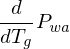

In [16]:
Delta_Pwa.definition.expr

In [17]:
generate_metadata_table([Delta_Pwa])

Symbol,Name,Description,Definition,Default value,Units
$\Delta$,Delta_Pwa,"Slope of saturated vapour pressure, $\partial P_{wa} / \partial T_g$",$\frac{d}{d T_g} P_{wa}$,-,K$^{-1}$ Pa


## Linking assumptions to variables
We can specify if a given variable is a complex, real, integer etc. by using the `assumptions` property during variable definition:

In [18]:
class x(Variable):
     """Positive real variable."""  
     assumptions = {'positive': True, 'real': True}

print(solve(x**2 - 1))

[1]


# Creating equations
Equations have a left hand side and a right hand side and if they contain variables with units, the units of each addend must be the same.

## Custom equation
To create custom equations, first import `Equation`:

In [19]:
from essm.equations import Equation

We will now define an equation representing the ideal gas law, based on the variables defined above:

In [20]:
class eq_ideal_gas_law(Equation):
    """Ideal gas law."""
    
    expr = Eq(P_g*V_g, n_g*R_mol*T_g)

Note that whenever an equation is defined, its units are checked for consistency in the background and if they are not consistent, an error message will be printed. To illustrate this, we will try to define the above equation again, but omit temperature on the right hand side:

In [21]:
try:
    class eq_ideal_gas_law(Equation):
        """Ideal gas law."""

        expr = Eq(P_g*V_g, n_g*R_mol)
except Exception as exc1:
    print(exc1)

Dimension of "R_mol*n_g" is Dimension(length**2*mass/(temperature*time**2)), but it should be the same as P_g*V_g, i.e. Dimension(length**2*mass/time**2)


The equation can be displayed in typesetted form, and the documentation string can be accessed in a similar way as for Variable:

In [22]:
display(eq_ideal_gas_law)
print(eq_ideal_gas_law.__doc__)

Ideal gas law.


## New equation based on manipulation of previous equations
We can use the above equation just as any Sympy expression, and e.g. solve it for pressure:

In [23]:
soln = solve(eq_ideal_gas_law, P_g, dict=True); print(soln)

[{P_g: R_mol*T_g*n_g/V_g}]


If we want to define a new equation based on a manipulation of eq_ideal_gas_law we can specify that the parent of the new equation is `eq_ideal_gas_law.definition`:

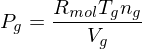

In [24]:
class eq_Pg(eq_ideal_gas_law.definition):
    """Calculate pressure of ideal gas."""
    
    expr = Eq(P_g, soln[0][P_g])
eq_Pg

We can also have nested inheritance, if we now define another equation based on eq_Pg:

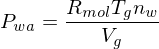

In [25]:
class eq_Pwa_nw(eq_Pg.definition):
    """Calculate vapour pressure from amount of water in gas."""
    
    expr = Eq(P_wa, eq_Pg.rhs.subs(n_g, n_w))
eq_Pwa_nw

### Show inheritance of equations
To see the inheritance of the newly created equation:

In [26]:
eq_Pwa_nw.definition.__bases__

(__main__.eq_Pg,)

In [27]:
[parent.name for parent in eq_Pwa_nw.definition.__bases__]

['eq_Pg']

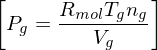

In [28]:
[parent.expr for parent in eq_Pwa_nw.definition.__bases__]

We can also write a function to get all parents recursively:

In [29]:
def get_parents(equation, allparents=set()):
    """Return set of recursive parents of equation."""
    
    parents = equation.definition.__bases__
    for parent in parents:
        if hasattr(parent, 'name'):
            allparents.update([parent.name])
            get_parents(eval(parent.name))
    return allparents
get_parents(eq_Pwa_nw)

{'eq_Pg', 'eq_ideal_gas_law'}

### Computational burden of deriving equations without class definition
If we solve for a variable to derive a new equation, is the solve() command performed every time this equation is used?

[{P_g: R_mol*T_g*n_g/V_g}]


/home/stan/Programs/essm/essm/equations/_core.py:105: UserWarning: "__main__:eq_Pg" will be overridden by "__main__:<class '__main__.eq_Pg1'>"
  instance[expr] = instance


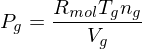

In [30]:
class eq_Pg1(eq_ideal_gas_law.definition):
    """Calculate pressure of ideal gas."""
    from sympy import solve
    soln = solve(eq_ideal_gas_law, P_g, dict=True); print(soln)
    expr = Eq(P_g, soln[0][P_g])
eq_Pg1

In [31]:
%time
eq_Pg.subs({R_mol: 8.314, T_g: 300, n_g: 0.1, V_g: 1})

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [32]:
%time
eq_Pg1.subs({R_mol: 8.314, T_g: 300, n_g: 0.1, V_g: 1})

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


There is actually no difference!

## Empirical equations with internal variables
Empirical equations not only contain variables but also numbers. As an example, we will try to define the Clausius-Clapeyron equation for saturation vapour pressure in the following example, after defining a few additional variables used in this equation.


In [33]:
from sympy.physics.units import joule, kilogram
class lambda_E(Variable):
    """Latent heat of evaporation."""
    unit = joule/kilogram
    latex_name = '\\lambda_E'
    default = 2.45e6   

class M_w(Variable):
    """Molar mass of water."""
    unit = kilogram/mole
    default = 0.018

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.physics.thermodynamics:lambda_E" will be overridden by "__main__:<class '__main__.lambda_E'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.physics.thermodynamics:M_w" will be overridden by "__main__:<class '__main__.M_w'>"
  instance[expr] = instance


In [34]:
from sympy import exp
try:
    class eq_Pwa_CC(Equation):
        """Clausius-Clapeyron P_wa as function of T_g. 

        \cite[Eq. B3]{hartmann_global_1994}
        """

        expr = Eq(P_wa, 611.*exp(-M_w*lambda_E*(1/T_g - 1/273.)/R_mol))
except Exception as exc1:
    print(exc1)

Dimension of "1/T_g" is Dimension(1/temperature), but it should be the same as -0.00366300366300366, i.e. Dimension(1)


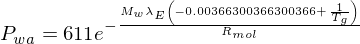

In [35]:
expr = Eq(P_wa, 611*exp(-M_w*lambda_E*(1/T_g - 1/273)/R_mol))
expr

The unit mismatch reported in the error message stems from the fact that the numbers in the empirical equation actually need units. Since the term in the exponent has to be non-dimensional, the units of `611` must be the same as those of `P_wa`, i.e. pascal. The units of the subtraction term in the exponent must match, meaning that `273` needs units of kelvin. To avoid the error message, we can define the empirical numbers as internal variables to the equation we want to define:

In [36]:
class eq_Pwa_CC(Equation):
    """Clausius-Clapeyron P_wa as function of T_g. 

    Eq. B3 in :cite{hartmann_global_1994}
    """
        
    class p_CC1(Variable):
        """Internal parameter of eq_Pwl."""
        unit = pascal
        latex_name = '611'
        default = 611.   
    
    
    
    class p_CC2(Variable):
        """Internal parameter of eq_Pwl."""
        unit = kelvin
        latex_name = '273'
        default = 273.   
    
    expr = Eq(P_wa, p_CC1*exp(-M_w*lambda_E*(1/T_g - 1/p_CC2)/R_mol))

In the above, we defined the latex representation of the empirical constants as their actual values, so the equation displays in the familiar way:

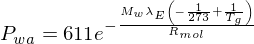

In [37]:
eq_Pwa_CC

All default values of variables defined along with the variable definitions are stored in a dictionary that can be accessed as `Variable.__defaults__`. We can substitute the values from this dictionary into our empirical equation to plot saturation vapour pressure as a function of temperature:

In [38]:
import matplotlib.pyplot as plt
from sympy import latex
from sympy import N
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown
def plot_expr(expr, xvar, yvar, xmin, xmax, clf=True):
    '''Plot expression as function for variable from xmin to xmax.'''
    
    if clf:
        plt.close
        plt.clf
    xstep = (xmax - xmin)/100
    xvals = arange(xmin, xmax, xstep)
    yvals = [N(expr.subs(xvar, dummy)) for dummy in xvals]
    plt.plot(xvals, yvals)
    plt.xlabel('$'+latex(xvar)+'$' + ' (' + markdown(derive_unit(xvar)) + ')')
    plt.ylabel('$'+latex(yvar)+'$' + ' (' + markdown(derive_unit(yvar)) + ')')
    plt.show()

Eq(P_wa, 167405731976.232*exp(-5304.00487246815/T_g))


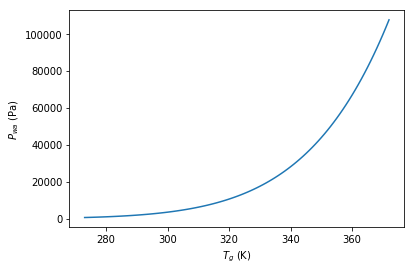

In [39]:
expr = eq_Pwa_CC.subs(Variable.__defaults__)
print(expr)
xvar = T_g
plot_expr(expr.rhs, T_g, P_wa, 273, 373)

## Piecewise defined equations

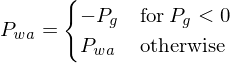

In [40]:
from sympy import Piecewise
expr = Eq(P_wa, Piecewise((-P_g, P_g < 0), (P_wa, P_g >= 0)))
expr

In [41]:
try:
    class eq1(Equation):
         """Test"""
         expr = Eq(P_wa, Piecewise((-P_g, P_g < 0), (P_wa, P_g >= 0)))
    display(eq1)
except Exception as e1:
    print(e1)

__new__() missing 1 required positional argument: 'cond'


**If the above returns a dimension error, then unit checking for `Piecewise` has not been implemented yet.**

# Substituting into derivatives and evaluating
Above, we defined `Delta_Pwa` as a variable that represents the partial derivative of `P_wa` with respect to `T_g`:
```
class Delta_Pwa(Variable):
    """Slope of saturated vapour pressure, $\partial P_{ws} / \partial T_g"""
    expr = P_wa(T_g).diff(T_g)
    #unit = pascal/kelvin
    latex_name = r'\Delta'
```
This definition can be accessed by typing `Delta_Pwa.definition.expr`. Example:

Derivative(P_wa, T_g)


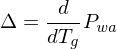

In [42]:
print(Delta_Pwa.definition.expr)
display(Eq(Delta_Pwa, Delta_Pwa.definition.expr))

We also defined the Clausius-Clapeyron approximation to $P_{wa}(T_g)$ as `eq_Pwa_CC`. 

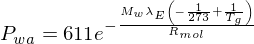

Clausius-Clapeyron P_wa as function of T_g. 

    Eq. B3 in :cite{hartmann_global_1994}
    


In [43]:
display(eq_Pwa_CC)
print(eq_Pwa_CC.__doc__)

If we want to substitute this approximation into `Delta_Pwa.definition.expr`, we need to use `replace` instead of `subs` and evaluate the derivative using `doit()`:

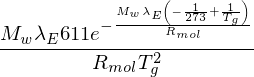

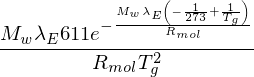

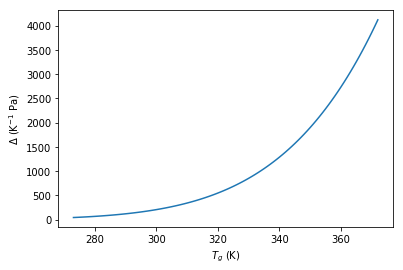

In [44]:
display(Delta_Pwa.definition.expr.subs(P_wa, eq_Pwa_CC.rhs).doit())
expr = Delta_Pwa.definition.expr.replace(P_wa, eq_Pwa_CC.rhs).doit()
display(expr)
plot_expr(expr.subs(Variable.__defaults__), T_g, Delta_Pwa, 273, 373)

## Unit conversions
Values for variables are often given in obscure units, but to convert to our standard units, we can use the dictionary `SI_EXTENDED_DIMENSIONS`:

In [45]:
from sympy.physics.units import convert_to, kilo, mega, joule, kilogram, meter, second, inch, hour
from essm.variables.units import SI_EXTENDED_DIMENSIONS, SI_EXTENDED_UNITS
value1 = 0.3
unit1 = inch/hour
print(value1*unit1)
unit2 = Variable.get_dimensional_expr(unit1).subs(SI_EXTENDED_DIMENSIONS)
print(convert_to(value1*unit1, unit2))

0.3*inch/hour
2.11666666666667e-6*m/s


# Plotting

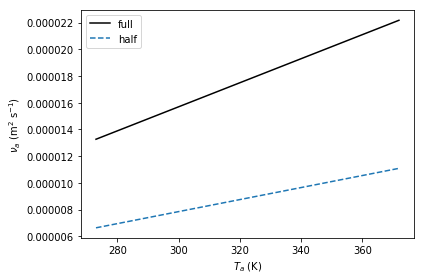

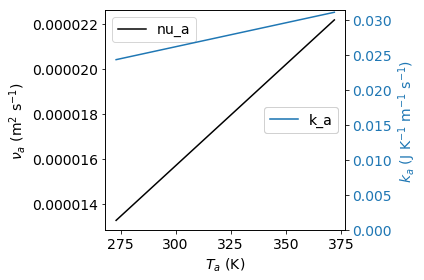

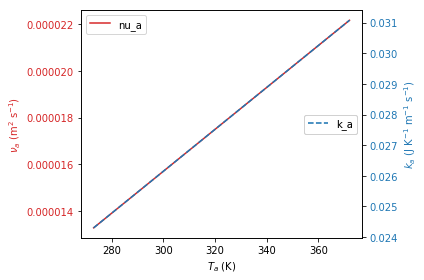

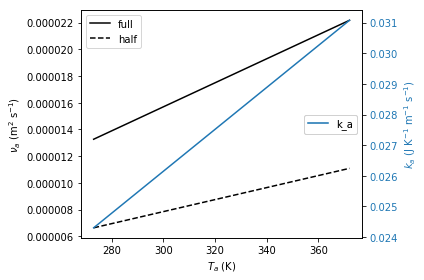

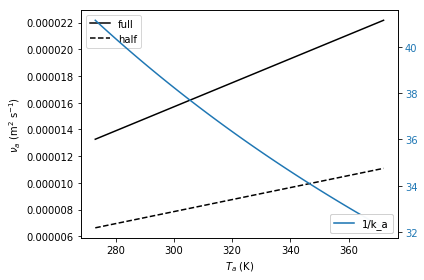

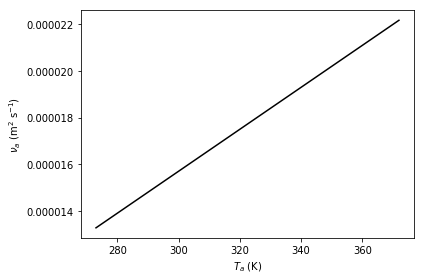

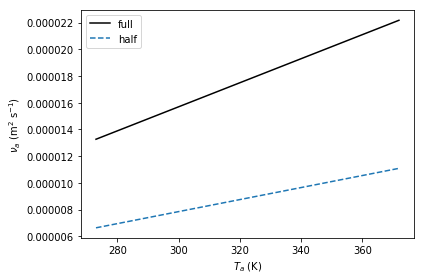

In [191]:
import matplotlib.pyplot as plt
from sympy import latex
from sympy import N
from numpy import arange
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import markdown

def plot_expr2(xvar_min_max, yldata, yllabel=None, yrdata=None,
               yrlabel='', clf=True, npoints=100, ylmin=None, ylmax=None,
               yrmin=None, yrmax=None,
               colors=['black', 'tab:blue', 'tab:red', 'tab:green'],
               loc_legend_left='best', loc_legend_right='right',
               linestylesl=['-', '--', '-.', ':'], 
               linestylesr=['-', '--', '-.', ':'],
               fontsize=None, fontsize_ticks=None, fontsize_labels=None,
               fontsize_legend=None,
               fig1=None, **args):
    '''
    Plot expressions as function of xvar from xmin to xmax.
    
    **Examples:**
    
    from essm.variables import Variable
    from essm.variables.physics.thermodynamics import T_a
    from essm.equations.physics.thermodynamics import eq_nua, eq_ka
    vdict = Variable.__defaults__.copy()    
    expr = eq_nua.subs(vdict)
    exprr = eq_ka.subs(vdict)
    xvar = T_a
    yldata = [(expr.rhs, 'full'), (expr.rhs/2, 'half')]
    yrdata = exprr
    plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a), yrdata=yrdata)
    plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a), 
               yrdata=[(1/exprr.lhs, 1/exprr.rhs)],
               loc_legend_right='lower right')
    plot_expr2((T_a, 273, 373), expr)
    plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a))
    '''
    (xvar, xmin, xmax) = xvar_min_max
    if fontsize:
        fontsize_labels = fontsize
        fontsize_legend = fontsize
        fontsize_ticks = fontsize
    if not fig1:
        plt.close
        plt.clf
        fig = plt.figure(**args)
    else: 
        fig = fig1
    if hasattr(xvar, 'definition'): 
        xlabel = '$'+latex(xvar)+'$'+ ' (' + markdown(derive_unit(xvar)) + ')'
    else: 
        xlabel = xvar
    if hasattr(yldata, 'lhs'):
        yldata = (yldata.rhs, yldata.lhs)
    if not yllabel:
        if type(yldata) is tuple:
            yllabel = yldata[1]
        else:
            try: 
                yllabel = yldata[0][1]
            except Exception as e1:
                print(e1)
                print('yldata must be equation or list of (expr, name) tuples')
                
    if type(yllabel) is not str: 
        yllabel = '$'+latex(yllabel)+'$'+ ' (' + markdown(derive_unit(yllabel)) + ')'     
    if type (yldata) is not list and type(yldata) is not tuple:
        # If only an expression given
        yldata = [(yldata, '')]
    if type(yldata[0]) is not tuple:
        yldata = [yldata]
    if yrdata is not None:
        if yrlabel == '':
            if hasattr(yrdata, 'lhs'):
                yrlabel = yrdata.lhs 
        if type (yrdata) is not list and type(yrdata) is not tuple:
            # If only an expression given
            yrdata = [yrdata] 
    if type(yrlabel) is not str: 
        yrlabel = '$'+latex(yrlabel)+'$'+ ' (' + markdown(derive_unit(yrlabel)) + ')'            
    
    xstep = (xmax - xmin)/npoints
    xvals = arange(xmin, xmax, xstep)
       
    ax1 =  fig.add_subplot(1, 1, 1)
    color = colors[0]
    if ylmin:    ax1.set_ylim(ymin=float(ylmin))
    if ylmax:    ax1.set_ylim(ymax=float(ylmax))
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(yllabel, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    i = 0
    for (expr1, y1var) in yldata:
        linestyle = linestylesl[i]
        if yrdata is None:
            color = colors[i]
        i= i + 1
        try: 
            y1vals = [expr1.subs(xvar, dummy).n() for dummy in xvals]                   
            ax1.plot(xvals, y1vals, color=color, linestyle=linestyle, label=y1var)
        except Exception as e1:
            print([expr1.subs(xvar, dummy) for dummy in xvals])
            print(e1)
    if i > 1 or yrdata is not None:
        plt.legend(loc=loc_legend_left, fontsize=fontsize_legend)
    
    if yrdata is not None:   
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = colors[1]
        ax2.set_ylabel(yrlabel, color=color)
        i = 0

        for item in yrdata:
            if type(item) is tuple:   # if item is tuple
                (expr2, y2var) = item
            else:
                try: 
                    (y2var, expr2) = (item.lhs, item.rhs)
                except Exception as e1:
                    print(e1)
                    print('yrdata must be a list of equations or tuples (var, expr)')
                    return
            linestyle = linestylesr[i]
            i = i + 1
            try:
                y2vals = [expr2.subs(xvar, dummy).n() for dummy in xvals]
                ax2.plot(xvals, y2vals, color=color, linestyle=linestyle, label=y2var)
            except Exception as e1:
                print(expr2)
                print([expr2.subs(xvar, dummy).n() for dummy in xvals])
                print(e1)
                
            if not yrlabel:
                if hasattr(yrdata[0], 'lhs'):
                    yrlabel = yrdata[0].lhs

        if type(yrlabel) is not str: 
            yrlabel = '$'+latex(yrlabel)+'$'+ ' (' + markdown(derive_unit(yrlabel)) + ')'       
        ax2.tick_params(axis='y', labelcolor=color)
        if yrmin:    ax2.set_ylim(ymin=float(yrmin))
        if yrmax:    ax2.set_ylim(ymax=float(yrmax))
        leg=ax2.legend(loc=loc_legend_right, fontsize=fontsize_legend)
        ax2.add_artist(leg);
        for item in ([ax2.xaxis.label, ax2.yaxis.label]):
            item.set_fontsize(fontsize_labels)
        ax2.tick_params(axis='both', which='major', labelsize=fontsize_ticks)

    for item in ([ax1.xaxis.label, ax1.yaxis.label]):
        item.set_fontsize(fontsize_labels)
    ax1.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    return fig

    
vdict = Variable.__defaults__.copy()    
expr = eq_nua.subs(vdict)
exprr = eq_ka.subs(vdict)
xvar = T_a
yldata = [(expr.rhs, 'full'), (expr.rhs/2, 'half')]
yrdata = exprr

plot_expr2((T_a, 273, 373), yldata=expr, yrdata=exprr, yrmin=-0.0001, fontsize=14) # note that yrmin=0 would have no effect
plot_expr2((T_a, 273, 373), yldata=expr, yrdata=exprr, colors=['tab:red', 'tab:blue'], linestylesr=['--'])
plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a), yrdata=yrdata)
plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a), yrdata=[(1/exprr.rhs, 1/exprr.lhs)],
           loc_legend_right='lower right')
plot_expr2((T_a, 273, 373), expr)
plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a))

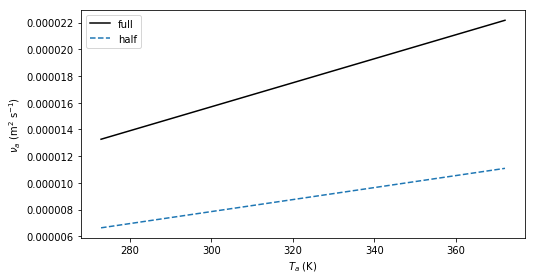

In [101]:
# Manipulate figure
fig = plot_expr2((T_a, 273, 373), yldata, yllabel = (nu_a))
%matplotlib inline
fig.set_figwidth(8)
fig

# Exporting definitions

In [47]:
print(meter)
strprinter_orig = StrPrinter._print_Quantity
StrPrinter._print_Quantity = lambda self, expr: str(expr.name)    # displays long units (meter instead of m)
print(meter)
StrPrinter._print_Quantity = strprinter_orig
print(meter)

m
meter
m


In [48]:
from sympy import preorder_traversal
def extract_units(expr):
    """Traverse through expression and return set of units."""
    return {
        arg
        for arg in preorder_traversal(expr) if isinstance(arg, Quantity)
    }

In [49]:
for variable in Variable.__registry__.keys():
    if hasattr(variable.definition, 'expr'):
        print(expr)

Eq(nu_a, 9.0e-8*T_a - 1.13e-5)


In [50]:
eq = Delta_Pwa.definition.expr
for arg in preorder_traversal(eq):
    print(arg.func)

<class 'sympy.core.function.Derivative'>
<class 'essm.variables._core.BaseVariable'>
<class 'sympy.core.containers.Tuple'>
<class 'essm.variables._core.BaseVariable'>
<class 'sympy.core.numbers.One'>


In [51]:
from sympy import sympify

sympify(eq.func)

sympy.core.function.Derivative

In [52]:
with open('test_definitions.py', 'wt') as file1:
    file1.write('from essm.variables._core import BaseVariable, Variable\n')
    file1.write('from essm.equations import Equation\n')
    file1.write('from sympy import Abs, exp, Float, log, nsolve, Eq, sqrt, solve, Derivative, Symbol\n')
    # Create import strings for all units
    strprinter_orig = StrPrinter._print_Quantity
    StrPrinter._print_Quantity = lambda self, expr: str(expr.name)    # displays long units (meter instead of m)
    s = set()
    for unit in Variable.__units__.values():
        for item in extract_units(unit):
            s.add(item)
    commandstr = 'from sympy.physics.units import ' + str(s)[1:-1]
    file1.write(commandstr.replace("\n", " ") + "\n")
    
    for variable in Variable.__registry__.keys():
        symbol = variable.definition.latex_name
        name = variable.name
        doc = variable.__doc__
        unit = variable.definition.unit
        assumptions = variable.definition.assumptions
        latex_name = variable.definition.latex_name
        expression = Variable.__expressions__.get(variable, None)
        default = str(Variable.__defaults__.get(variable, None))
        commandstr = '''{0} = type('{0}', (Variable,), {{'__doc__': """{1}""", 'unit': {2}, 'assumptions': {3}, \
        'latex_name': r'{4}', 'default': {5}, 'expr': {6}}})'''.format(name, doc, unit, assumptions, latex_name,\
        default, expression)
        file1.write(commandstr + "\n")
        
    for eq in Equation.__registry__.keys():
        name = eq.definition.name
        doc = eq.__doc__
        equ = eq
        commandstr = '''{0} = type('{0}', (Equation,), {{'__doc__': """{1}""", 'expr': {2}}})'''.format(name, doc, equ)
        file1.write(commandstr + "\n")
        
    StrPrinter._print_Quantity = strprinter_orig    # restore original

In [53]:
from test_definitions import *

/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.chamber.insulation:c_pi" will be overridden by "essm.variables._core:<class 'essm.variables._core.c_pi'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.chamber.insulation:lambda_i" will be overridden by "essm.variables._core:<class 'essm.variables._core.lambda_i'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.chamber.insulation:rho_i" will be overridden by "essm.variables._core:<class 'essm.variables._core.rho_i'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.chamber.insulation:L_i" will be overridden by "essm.variables._core:<class 'essm.variables._core.L_i'>"
  instance[expr] = instance
/home/stan/Programs/essm/essm/variables/_core.py:87: UserWarning: "essm.variables.chamber.insulation:A_i" will be overridden by 

In [54]:
with open('test_definitions.py', 'wt') as file1:
    file1.write('from essm.variables._core import BaseVariable, Variable\n')
    file1.write('from essm.equations import Equation\n')
    # Create import strings for all units
    StrPrinter._print_Quantity = lambda self, expr: str(expr.name)    # displays long units (meter instead of m)
    s = set()
    for unit in Variable.__units__.values():
        for item in extract_units(unit):
            s.add(item)
    commandstr = 'from sympy.physics.units import ' + str(s)[1:-1]
    file1.write(commandstr.replace("\n", " ") + "\n")
    
    for variable in Variable.__registry__.keys():
        symbol = variable.definition.latex_name
        name = variable.name
        doc = variable.__doc__
        unit = variable.definition.unit

        expression = Variable.__expressions__.get(variable, None)
        default = str(Variable.__defaults__.get(variable, None))
        commandstr = '''{0} = type('{0}', (Variable,), {{'__doc__': """{1}""", 'unit': {2}, 'assumptions': {3}, \
        'latex_name': r'{4}', 'default': {5}, 'expr': {6}}})'''.format(name, doc, unit, assumptions, latex_name,\
        default, expression)
        file1.write(commandstr + "\n")
        
    for eq in Equation.__registry__.keys():
        name = eq.definition.name
        doc = eq.__doc__
        equ = eq
        commandstr = '''{0} = type('{0}', (Equation,), {{'__doc__': """{1}""", 'expr': {2}}})'''.format(name, doc, equ)
        file1.write(commandstr + "\n")
        
    StrPrinter._print_Quantity = lambda self, expr: str(expr.expr)    # displays short units 

In [55]:
from test_definitions import *

# Numerical evaluations
See here for detailed instructions on how to turn sympy expressions into code: https://docs.sympy.org/latest/modules/codegen.html

In [56]:
for eq in Equation.__registry__.keys():
        print(eq.definition.name + ': ' + str(eq))

eq_Qi: Eq(Q_i, A_i*dT_i*lambda_i/L_i)
eq_Le: Eq(Le, alpha_a/D_va)
eq_Cwa: Eq(C_wa, P_wa/(R_mol*T_a))
eq_Nu_forced_all: Eq(Nu, -Pr**(1/3)*(-37*Re**(4/5) + 37*(Re + Re_c - Abs(Re - Re_c)/2)**(4/5) - 664*sqrt(Re + Re_c - Abs(Re - Re_c)/2))/1000)
eq_Dva: Eq(D_va, T_a*p_Dva1 - p_Dva2)
eq_alphaa: Eq(alpha_a, T_a*p_alpha1 - p_alpha2)
eq_ka: Eq(k_a, T_a*p_ka1 + p_ka2)
eq_nua: Eq(nu_a, T_a*p_nua1 - p_nua2)
eq_rhoa_Pwa_Ta: Eq(rho_a, (M_N2*P_N2 + M_O2*P_O2 + M_w*P_wa)/(R_mol*T_a))
eq_Pa: Eq(P_a, P_N2 + P_O2 + P_wa)
eq_PN2_PO2: Eq(P_N2, P_O2*x_N2/x_O2)
eq_PO2: Eq(P_O2, (P_a*x_O2 - P_wa*x_O2)/(x_N2 + x_O2))
eq_PN2: Eq(P_N2, (P_a*x_N2 - P_wa*x_N2)/(x_N2 + x_O2))
eq_rhoa: Eq(rho_a, (x_N2*(M_N2*P_a - P_wa*(M_N2 - M_w)) + x_O2*(M_O2*P_a - P_wa*(M_O2 - M_w)))/(R_mol*T_a*x_N2 + R_mol*T_a*x_O2))
eq_ideal_gas_law: Eq(P_g*V_g, R_mol*T_g*n_g)
eq_Pg: Eq(P_g, R_mol*T_g*n_g/V_g)
eq_Pwa_nw: Eq(P_wa, R_mol*T_g*n_w/V_g)
eq_Pwa_CC: Eq(P_wa, p_CC1*exp(-M_w*lambda_E*(-1/p_CC2 + 1/T_g)/R_mol))
eq_Nu_forced_all: Eq(Nu,

## Evaluation of equations for long lists of variable sets
Substitution of variables into equations takes a lot of time if they need to be evaluated for a large number of variables. We can use theano to speed this up:

In [57]:
#import theano
from sympy.printing.theanocode import theano_function
import numpy as np

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We will now create two long lists of values representing T_g and n_g respectively and show how long it takes to compute ideal gas law values.

In [58]:
npoints = 10000
xmin = 290.
xmax = 310.
Tvals = np.arange(xmin, xmax, (xmax - xmin)/npoints)
xmin = 0.1
xmax = 0.5
nvals = np.arange(xmin, xmax, (xmax-xmin)/npoints)

In [59]:
%%time
# looping
expr = eq_ideal_gas_law.rhs.subs(Variable.__defaults__)
resvals0 = []
for i in range(len(Tvals)):
    resvals0.append(expr.subs({T_g: Tvals[i], n_g: nvals[i]}))

CPU times: user 7.72 s, sys: 3.41 ms, total: 7.73 s
Wall time: 7.73 s


In [60]:
%%time
# Using theano
f1 = theano_function([T_g, n_g], [eq_ideal_gas_law.rhs.subs(Variable.__defaults__)], dims={T_g:1, n_g:1})
resvals1 = f1(Tvals,nvals)

CPU times: user 158 ms, sys: 47.9 ms, total: 206 ms
Wall time: 2.13 s


In [61]:
list(resvals0) == list(resvals1)

True

**Both approaches give identical results, but `theano_function` makes it a lot faster.**

## Numerical solution
Some equations cannot be solved analytically for a given variable, e.g. eq_Nu_forced_all cannot be solved analytically for Re if Nu is given, so we can use numerical solvers instead:

In [62]:
from sympy import nsolve

In [63]:
vdict = Variable.__defaults__.copy()
vdict[Pr] = 0.71
vdict[Re_c] = 3000.
vdict[Nu] = 1000.
expr = eq_Nu_forced_all.subs(vdict)
nsolve(expr, 1000.)

Now applying to a long list of Nu-values:

In [64]:
npoints = 100
xmin = 1000.
xmax = 1200.
Nuvals = np.arange(xmin, xmax, (xmax - xmin)/npoints)

In [65]:
%%time
# Solving for a range of Nu values
vdict = Variable.__defaults__.copy()
vdict[Pr] = 0.71
vdict[Re_c] = 3000.
resvals = []
for Nu1 in Nuvals:
    vdict[Nu] = Nu1
    resvals.append(nsolve(eq_Nu_forced_all.subs(vdict), 1000.))

CPU times: user 2.32 s, sys: 10.1 ms, total: 2.33 s
Wall time: 2.33 s


We will now again use a theano function to make it faster. First we import optimize from scipy and preapre the theano_function:

In [66]:
import scipy.optimize as sciopt
vdict = Variable.__defaults__.copy()
vdict[Pr] = 0.71
vdict[Re_c] = 3000.
expr = eq_Nu_forced_all.subs(vdict)
expr1 = expr.rhs - expr.lhs
fun_tf = theano_function([Re, Nu], [expr1], dims={Nu:1, Re:1})
x0vals = np.full(Nuvals.shape, fill_value=2000.) # array of same shape as Nuvals, with initial guess

In [67]:
%%time
# Solving for a range of Nu values
resvals1 = sciopt.fsolve(fun_tf, args=Nuvals, x0=x0vals)

CPU times: user 5.73 ms, sys: 3.16 ms, total: 8.89 ms
Wall time: 17.1 ms


In [68]:
np.mean(abs((resvals - resvals1)/resvals))

**Using theano and scipy makes it 2 orders of magnitude faster and the results are different only by 10$^{-10}$%!**
**NOte, however, that scipy gets slowed down for large arrays, so it is more efficient to re-run it repreatedly with subsection of the arra:**

In [69]:
npoints = 1000
xmin = 1000.
xmax = 1200.
Nuvals = np.arange(xmin, xmax, (xmax - xmin)/npoints)
x0vals = np.full(Nuvals.shape, fill_value=2000.)

In [70]:
%%time
# Solving for a range of Nu values
resvals1 = sciopt.fsolve(fun_tf, args=Nuvals, x0=x0vals)

CPU times: user 1.9 s, sys: 9.49 ms, total: 1.91 s
Wall time: 1.91 s


We will now test that we can process Nuvals bit by bit and re-create it consistently:

In [71]:
%%time
# Solving for a range of Nu values
imax = len(Nuvals)
i0 = 0
idiff = 100
i1 = i0
resvals2 = []
while i1 < imax - 1:
    i0 = i1    # note that resvals[0:2] + resvals[2:4] = resvals[0:4]
    i1 = min(i0+idiff, imax)
    resvals0 = Nuvals[i0:i1]
    resvals2 = np.append(resvals2,resvals0)
print(list(resvals2) == list(Nuvals))

True
CPU times: user 3.14 ms, sys: 0 ns, total: 3.14 ms
Wall time: 2.91 ms


Now we will run fsolve for portions of Nuvals bit by bit:

In [72]:
%%time
# Solving for a range of Nu values
imax = len(Nuvals)
i0 = 0
idiff = 100
i1 = i0
resvals2 = []
while i1 < imax - 1:
    i0 = i1    # note that resvals[0:2] + resvals[2:4] = resvals[0:4]
    i1 = min(i0+idiff, imax)
    resvals0 = sciopt.fsolve(fun_tf, args=Nuvals[i0:i1], x0=x0vals[i0:i1])
    resvals2 = np.append(resvals2,resvals0)

CPU times: user 73.6 ms, sys: 0 ns, total: 73.6 ms
Wall time: 73.4 ms


In [73]:
np.mean(abs((resvals1 - resvals2)/resvals1))

**It is strange that resvals1 and resvals2 are different at all, but anyway, it is clear that slicing the data in relatively small portions is important to keep `scipy.optimize.fsolve` time-efficient.**

## Generate code from sympy expressions and execute
Need to install gfortran system-wide first!

In [74]:
from sympy.utilities.autowrap import autowrap

In [75]:
from sympy import symbols
x, y, z = symbols('x y z')
expr = ((x - y + z)**(13)).expand()
binary_func = autowrap(expr)

In [76]:
%%time
binary_func(1, 4, 2)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 13.8 µs


In [77]:
%%time
expr.subs({x:1, y:4, z:2})

CPU times: user 63.7 ms, sys: 12 ms, total: 75.7 ms
Wall time: 74.4 ms


In [78]:
from sympy.utilities.autowrap import binary_function
binary_function?